# Setup

In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd

import seaborn as sns

# sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(11,8)})
sns.set(font_scale=1.5)

In [2]:
class KArmedBandit:
    def __init__(self, k=10):
        
        self.k = k
        self.action_values = np.random.standard_normal(size=self.k)

    def graph(self):        
        
        rewards = [np.random.normal(av, 1, size=5000) for av in self.action_values]  # used for graphing only
        
        temp_df = pd.DataFrame({'q*': self.action_values, 'reward_dist': rewards})
        temp_df = pd.DataFrame({
                  col:np.repeat(temp_df[col].values, temp_df['reward_dist'].str.len())
                  for col in temp_df.columns.drop('reward_dist')}).assign(**{'reward_dist':np.concatenate(temp_df['reward_dist'].values)})[temp_df.columns]
        
        ax = sns.violinplot(x='q*', y='reward_dist', data=temp_df, order=self.action_values)
        
        ax.set_title('\nRandomly-Genereated Multi-Armed Bandit\n')
        ax.set_xlabel('\nAction')
        ax.set_ylabel('Reward Distribution\n')
        ax.set_xticklabels(np.arange(0, self.k))
        
    def give_reward(self, action):
        return np.random.normal(self.action_values[action], 1)
        

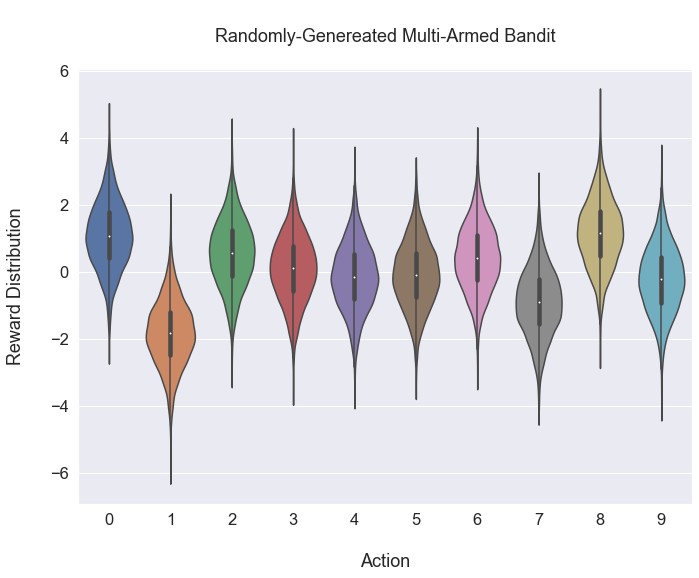

In [3]:
K = 10
bandit = KArmedBandit(K)
bandit.graph()  # The agent does not have this knowledge

Next, several methods for discovering the optimal action will be implemented.

# Helper Functions

In [4]:
# Similar to np.argmax, but provides all indices instead of only the first.
# https://stackoverflow.com/questions/17568612/how-to-make-numpy-argmax-return-all-occurrences-of-the-maximum

def allmax(a):
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_

# Greedy Policy

The agent will always choose the best action (indicated by the largest q-value in q_values). If multiple actions give the same reward, an action will be chosen randomly and uniformly.

See Sutton & Barto 2.4 for incremental update derivation.

In [5]:
STEPS = 50_000

q_values = np.zeros(K)
action_count = np.zeros(K)  # number of times an action has been selected, required to update q-value

for step in range(0, STEPS):
    
    greedy_action = np.random.choice(allmax(q_values))
    
    action_count[greedy_action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(greedy_action)
    q_values[greedy_action] = q_values[greedy_action] + (1/action_count[greedy_action]) * (reward - q_values[greedy_action])


for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: 0.0
ACTION: 1 	 Q-VALUE: -2.4395630917679494
ACTION: 2 	 Q-VALUE: 0.0
ACTION: 3 	 Q-VALUE: -0.24777373753251175
ACTION: 4 	 Q-VALUE: -0.09399668467286784
ACTION: 5 	 Q-VALUE: -0.023237970324834233
ACTION: 6 	 Q-VALUE: 0.41867184283891234
ACTION: 7 	 Q-VALUE: -0.5990451288833923
ACTION: 8 	 Q-VALUE: -0.12968027403512394
ACTION: 9 	 Q-VALUE: -2.0489000169900686
BEST ACTION: 6


Clearly, some actions are never even tried. In this example, once a single Q-value becomes greater than 0, it is chosen 100% of the time. This lack of exploration can mean that the optimal action is never discovered by the agent. One common solution to this is to introduce epsilon, a small probability of randomly choosing uniformly between all actions, regardless of action-value. This 'epsilon-greedy' method will be implemented below.

# Epsilon-Greedy Policy

Frequently, the agent chooses the best action, similar to the greedy policy above. However, for a small probability epsilon, the agent randomly selects among all actions uniformly.

In [6]:
STEPS = 50_000
EPSILON = 0.01  # random action is chosen 1% of the time

q_values = np.zeros(K)
action_count = np.zeros(K)  # number of times an action has been selected, required to update q-value

for step in range(0, STEPS):
    
    prob = np.random.rand()
    
    if prob >= EPSILON:  # greedy
        action = np.random.choice(allmax(q_values))
    
    else:  # exploration
        action = np.random.choice(np.arange(0, K))
    
    
    action_count[action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(action)
    q_values[action] = q_values[action] + (1/action_count[action]) * (reward - q_values[action])


for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: 1.0876257601984614
ACTION: 1 	 Q-VALUE: -1.7768970809622426
ACTION: 2 	 Q-VALUE: 0.5093385991284569
ACTION: 3 	 Q-VALUE: -0.048688923022078986
ACTION: 4 	 Q-VALUE: -0.09032713738801408
ACTION: 5 	 Q-VALUE: -0.2168974222511376
ACTION: 6 	 Q-VALUE: 0.39230558807145405
ACTION: 7 	 Q-VALUE: -1.0288309246422256
ACTION: 8 	 Q-VALUE: 1.147637105604881
ACTION: 9 	 Q-VALUE: 0.007692600081979669
BEST ACTION: 8


The optimal action is found with more certainty. Also, all actions are now being tried.

Other additions to a solution include optimistic initial value selection, upper-confidence-bound action selection, and support for nonstationary problems. These ideas will be implemented below.

# Optimistic Initial Value Selection

If we have an idea of possible rewards the agent can receive, we can initialize our Q-values in a way that encourages exploration. If all actions initially appear excellent, once one is updated closer to its actual worth, the other untested actions are still contenders in a greedy scenario. However, this alone is not sufficient in general, and particularly for nonstationary problems. See Sutton & Barto 2.6 for more information about potential benefits and drawbacks.

This method will be implemented with a greedy policy.

In [7]:
STEPS = 50_000

q_values = np.full((K, ), 7, dtype=np.float)  # initialize q_values to an array of 7s instead of 0s
action_count = np.zeros(K)  # number of times an action has been selected, required to update q-value

for step in range(0, STEPS):
    
    greedy_action = np.random.choice(allmax(q_values))
    
    action_count[greedy_action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(greedy_action)
    q_values[greedy_action] = q_values[greedy_action] + (1/action_count[greedy_action]) * (reward - q_values[greedy_action])

for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: 1.113566767958447
ACTION: 1 	 Q-VALUE: -2.315811168902961
ACTION: 2 	 Q-VALUE: -1.0449168137236686
ACTION: 3 	 Q-VALUE: -0.5145992057248474
ACTION: 4 	 Q-VALUE: 1.0095005112318693
ACTION: 5 	 Q-VALUE: -0.02424836963483923
ACTION: 6 	 Q-VALUE: 0.3527540313422497
ACTION: 7 	 Q-VALUE: -0.7323046378217963
ACTION: 8 	 Q-VALUE: 0.9100408443481385
ACTION: 9 	 Q-VALUE: 0.6727397240848196
BEST ACTION: 0


All actions are tried-- an improvement over the greedy policy. But, as more steps are taken, less exploration occurs. Also, the optimal action is sometimes not found after the predetermined 50,000 steps.

# Upper-Confidence-Bound Action Selection

This method selects among actions "according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates" (Sutton & Barto 2.7). Usually performs well, but is difficult to extend beyond bandits to nonstationary problems. Large state spaces also pose an issue.

In [8]:
STEPS = 50_000
C = 2  # controls the degree of exploration

q_values = np.zeros(K)
action_count = np.ones(K)  # number of times an action has been selected, required to update q-value. initialize to 1s to avoid divide-by-zero errors.

for step in range(1, STEPS+1):
    
    temp_arr = [q_values[a] + C * np.sqrt(np.log(step) / action_count[a]) for a in np.arange(0, K)]
    
    action = np.argmax(temp_arr)
    
    action_count[action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(action)
    q_values[action] = q_values[action] + (1/action_count[action]) * (reward - q_values[action])


for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: 1.1130281639508988
ACTION: 1 	 Q-VALUE: -1.8457185481391363
ACTION: 2 	 Q-VALUE: 0.5618657256459885
ACTION: 3 	 Q-VALUE: 0.26303325406323147
ACTION: 4 	 Q-VALUE: -0.03325181430427848
ACTION: 5 	 Q-VALUE: -0.035577825585742226
ACTION: 6 	 Q-VALUE: 0.3244479251326007
ACTION: 7 	 Q-VALUE: -0.317609640258847
ACTION: 8 	 Q-VALUE: 1.1428522429573509
ACTION: 9 	 Q-VALUE: -0.6188965934760893
BEST ACTION: 8


Unlike epsilon-greedy methods which can take a long time to explore, UCB can examine an action's potential. Many real-world bandit problems have been solved using UCB.

# Nonstationary Problems

Nonstationary problems are very common in RL. In nonstationary problems, the reward distribution does not stay the same. To account for this, more weight is given to recent rewards. This is accomplished by using a constant step-size parameter alpha.

The epsilon-greedy policy will be updated below to include this.

In [9]:
STEPS = 50_000
EPSILON = 0.01  # random action is chosen 1% of the time
ALPHA = 0.1  # constant step-size

q_values = np.zeros(K)
action_count = np.zeros(K)  # number of times an action has been selected, required to update q-value

for step in range(0, STEPS):
    
    prob = np.random.rand()
    
    if prob >= EPSILON:  # greedy
        action = np.random.choice(allmax(q_values))
    
    else:  # exploration
        action = np.random.choice(np.arange(0, K))
    
    
    action_count[action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(action)
    q_values[action] = q_values[action] + ALPHA * (reward - q_values[action])


for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: 1.659696909124827
ACTION: 1 	 Q-VALUE: -1.653905532757254
ACTION: 2 	 Q-VALUE: 0.25795146340359976
ACTION: 3 	 Q-VALUE: 0.15990979976662073
ACTION: 4 	 Q-VALUE: 0.28011530876263113
ACTION: 5 	 Q-VALUE: -0.2510370468181059
ACTION: 6 	 Q-VALUE: 0.267430570946343
ACTION: 7 	 Q-VALUE: -1.130634486542945
ACTION: 8 	 Q-VALUE: 0.48108265400738626
ACTION: 9 	 Q-VALUE: -0.1823582113457083
BEST ACTION: 0
